# Imports

In [1]:
import pathlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

In [3]:
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape
from pmdarima.pipeline import Pipeline
from pmdarima.model_selection import (train_test_split, 
                                      cross_val_score, 
                                      RollingForecastCV)

# Constants

In [4]:
PROJECT_DIR = pathlib.Path('~/work').expanduser()
DATA_DIR = PROJECT_DIR / 'data'

# Data

In [5]:
data_fb = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'FB.csv', 
    parse_dates=['Date'], 
    index_col=['Date']
)

In [6]:
data_temp = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'Mean_Temp_IMD_2017.csv',
    parse_dates=['YEAR'],
    index_col=['YEAR']
)

In [7]:
data_births = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'daily-total-female-births-CA.csv',
    index_col=['date'],
    parse_dates=['date']
)

# Types of Stationary Behavior in a Time Series

## data_fb

In [8]:
series = data_fb['Close']

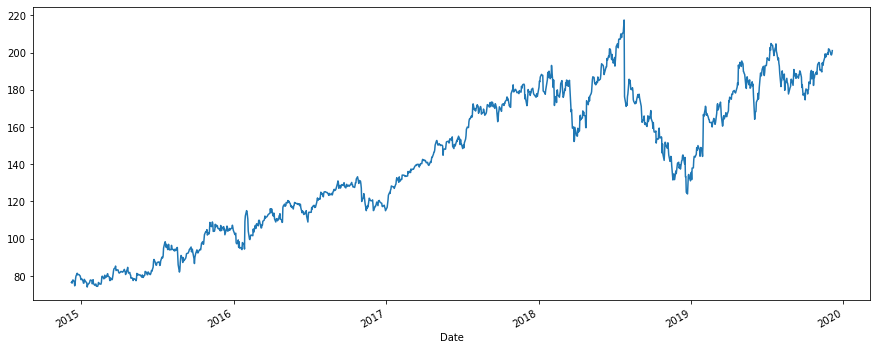

In [9]:
series.plot(figsize=(15, 6))
plt.show()

In [10]:
d = ndiffs(series, alpha=0.05, test='adf')
d

1

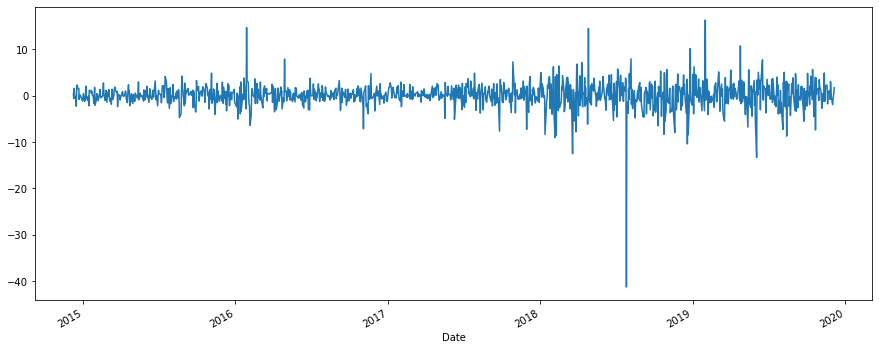

In [11]:
series.diff(d).plot(figsize=(15, 6))
plt.show()

In [12]:
ndiffs(series.diff(d).dropna(), alpha=0.05, test='adf')

0

## data_temp

In [13]:
series = data_temp['ANNUAL_AVG_TEMPRATURE']

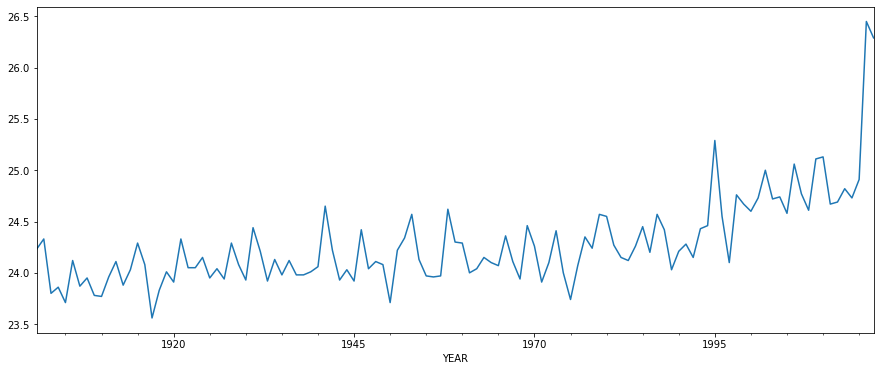

In [14]:
series.plot(figsize=(15, 6))
plt.show()

In [15]:
d = ndiffs(series, alpha=0.05, test='adf')
d

1

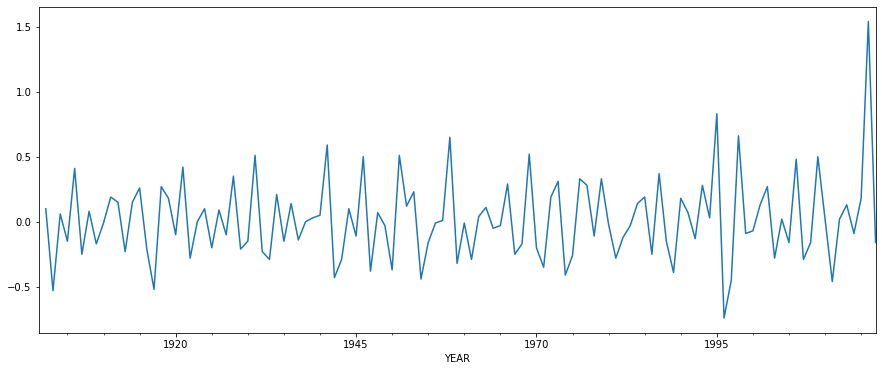

In [16]:
series.diff(d).plot(figsize=(15, 6))
plt.show()

In [17]:
ndiffs(series.diff(d).dropna(), alpha=0.05, test='adf')

0

# AR

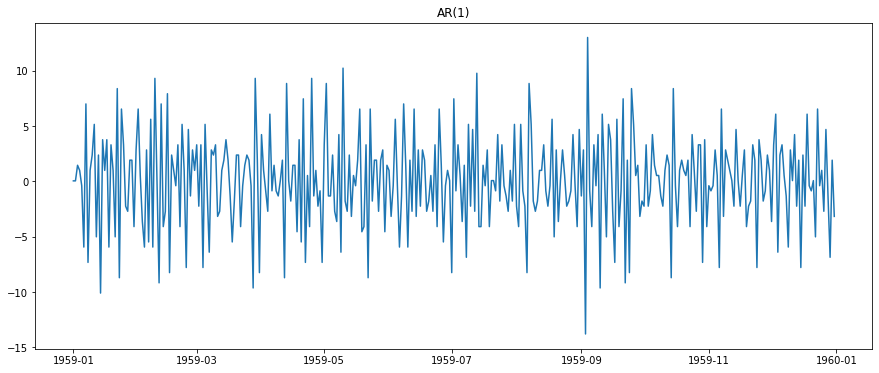

In [18]:
model_ar1 = pm.ARIMA(order=(1, 0, 0))
model_ar1.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ar1.predict_in_sample())
plt.title('AR(1)')
plt.show()

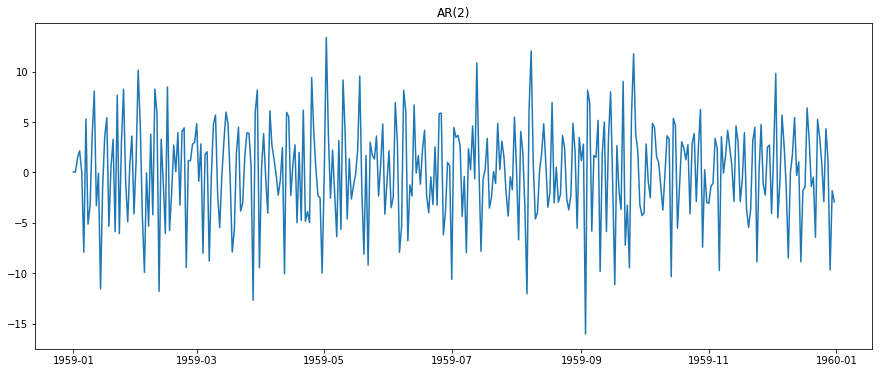

In [19]:
model_ar2 = pm.ARIMA(order=(2, 0, 0))
model_ar2.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ar2.predict_in_sample())
plt.title('AR(2)')
plt.show()

# MA

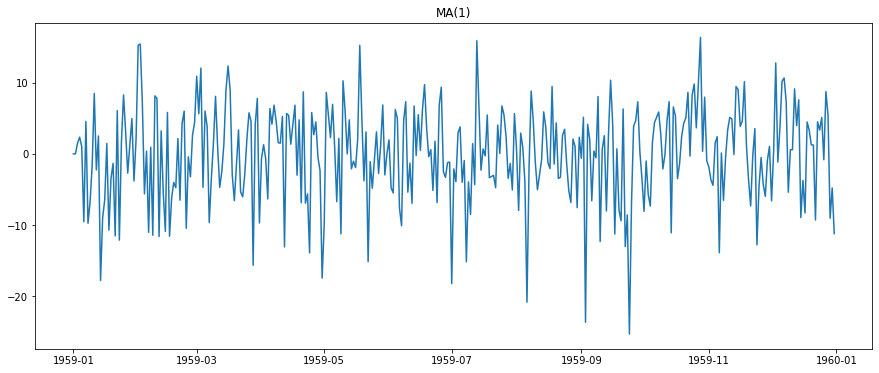

In [20]:
model_ma1 = pm.ARIMA(order=(0, 0, 1))
model_ma1.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ma1.predict_in_sample())
plt.title('MA(1)')
plt.show()

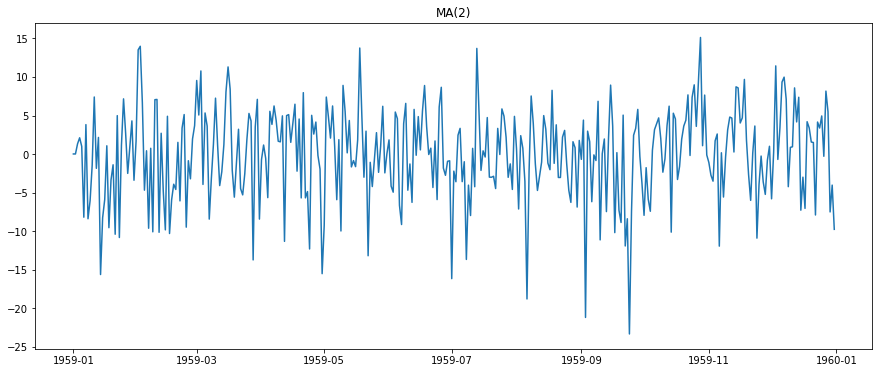

In [21]:
model_ma2 = pm.ARIMA(order=(0, 0, 2))
model_ma2.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ma2.predict_in_sample())
plt.title('MA(2)')
plt.show()

# ACF and PACF

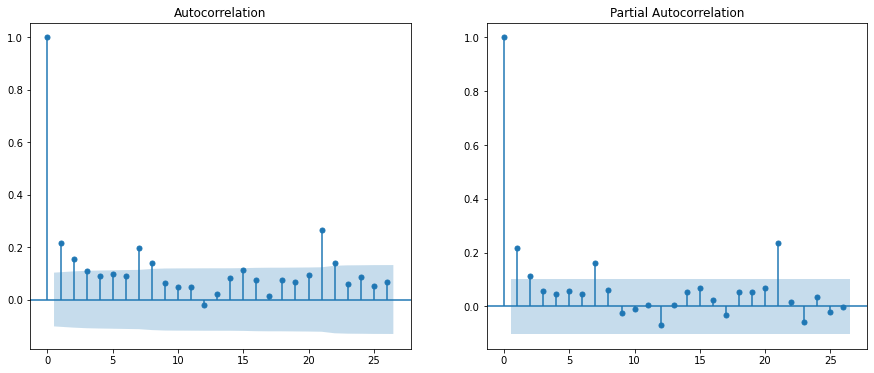

In [22]:
%%capture --no-display
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
pm.plot_acf(data_births['births'], alpha=0.05, ax=ax1, show=False)
pm.plot_pacf(data_births['births'], alpha=0.05, ax=ax2, show=False)
plt.show()

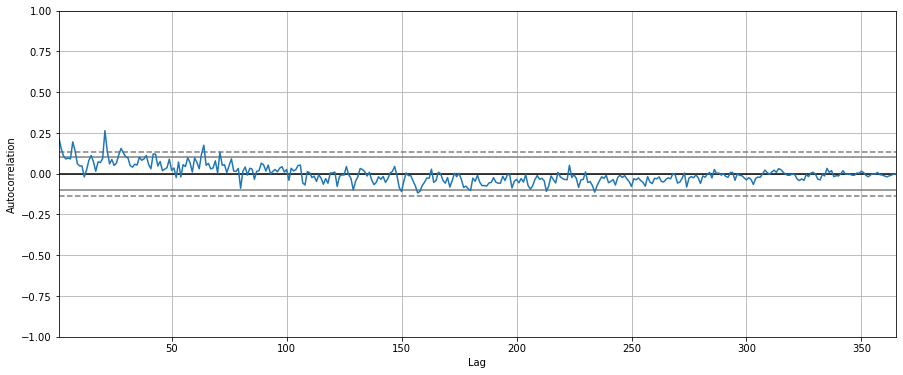

In [23]:
plt.figure(figsize=(15, 6))
pm.autocorr_plot(data_births['births'])

# ARIMA

In [11]:
train, test = pm.model_selection.train_test_split(data_fb['Close'], test_size=30)

In [12]:
train.head()

Date
2014-12-08    76.519997
2014-12-09    76.839996
2014-12-10    76.180000
2014-12-11    77.730003
2014-12-12    77.830002
Name: Close, dtype: float64

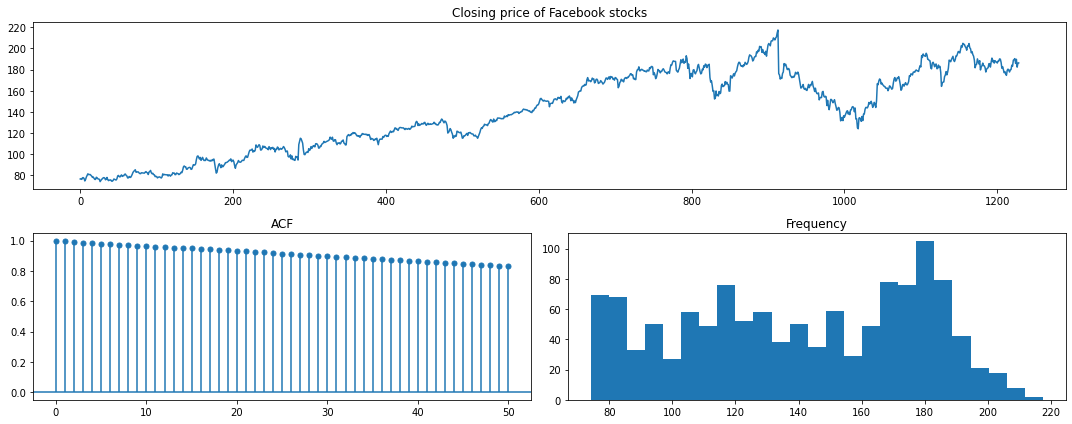

In [13]:
%%capture --no-display
pm.tsdisplay(
    y=train, 
    figsize=(15, 6),
    title="Closing price of Facebook stocks"
)

In [14]:
pm.arima.ndiffs(train, alpha=0.05, test='adf')

1

In [28]:
pipeline = Pipeline([
    ('model', pm.AutoARIMA(seasonal=False, 
                           information_criterion='aicc', 
                           suppress_warnings=True, 
                           error_action='ignore', 
                           trace=False))
])

In [29]:
cv_scores = cross_val_score(
    estimator=pipeline, 
    y=train, 
    scoring='smape', 
    cv=RollingForecastCV(h=30, step=30)
)

In [30]:
cv_scores.mean(), cv_scores.std()

(4.364325956325221, 2.8420212000009726)

In [31]:
pipeline.fit(train)

Pipeline(steps=[('model',
                 AutoARIMA(error_action='ignore', information_criterion='aicc',
                           seasonal=False))])

In [32]:
pipeline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1229
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2959.396
Date:                Tue, 29 Dec 2020   AIC                           5926.792
Time:                        23:32:08   BIC                           5947.245
Sample:                             0   HQIC                          5934.488
                               - 1229                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0122      0.012      1.046      0.296      -0.011       0.035
ar.L1          0.8631      0.087      9.909      0.000       0.692       1.034
ma.L1         -0.8999      0.076    -11.854      0.000      -1.049      -0.751
sigma2         7.2569      0.083     87.805      0.000       7.095       7.419
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):            112080.82
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               4.99   Skew:                            -2.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
forecast, conf_int = pipeline.predict(n_periods=30, return_conf_int=True)

In [34]:
smape(test, forecast)

4.013560615329413

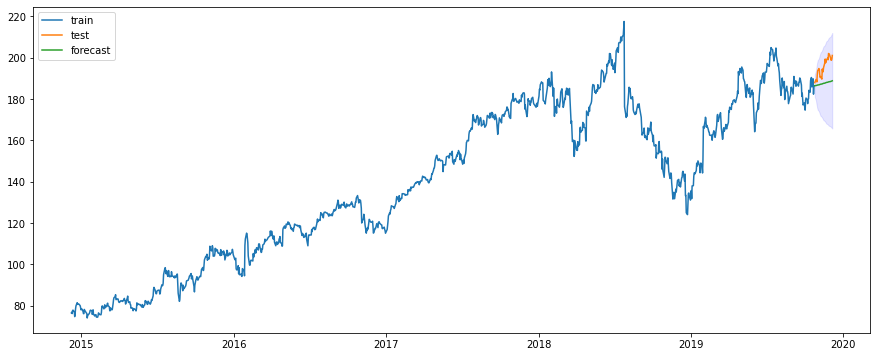

In [35]:
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(test.index, forecast, label='forecast')
plt.fill_between(x=test.index, 
                 y1=conf_int[:, 0], 
                 y2=conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()

# SARIMA

In [8]:
train, test = pm.model_selection.train_test_split(
    pm.datasets.load_gasoline(as_series=True), 
    test_size=52
)

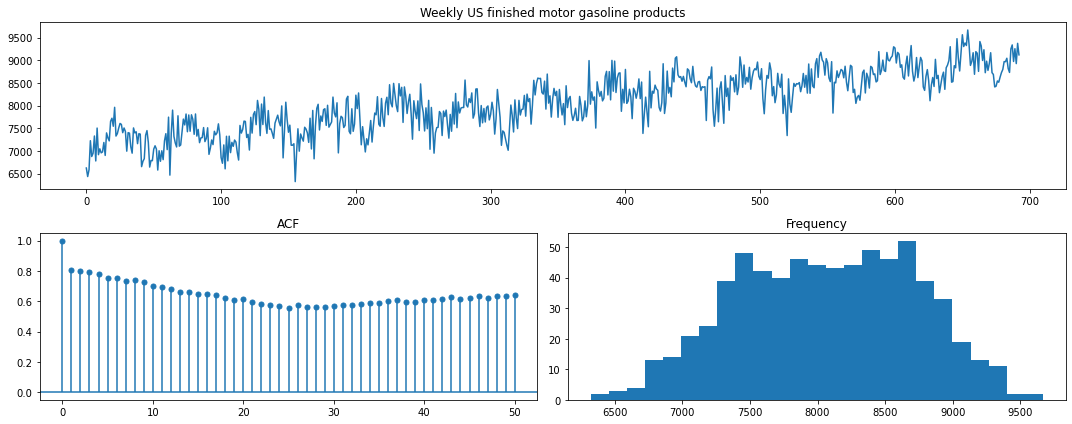

In [9]:
%%capture --no-display
pm.tsdisplay(
    y=train, 
    figsize=(15, 6),
    title="Weekly US finished motor gasoline products"
)

In [10]:
def trend_strength(x, m):
    d = pm.decompose(x, 'additive', m=m)
    return max(0, 1 - np.nanvar(d.random)/np.nanvar(d.random + d.trend))

def seasonality_strength(x, m):
    d = pm.decompose(x, 'additive', m=m)
    return max(0, 1 - np.nanvar(d.random)/np.nanvar(d.random + d.seasonal))

In [11]:
season_df = pd.DataFrame(
    data=[(m, seasonality_strength(train, m)) 
          for m in range(2, 70)],
    columns=['m', 'seasonality_strength']
)

In [12]:
(season_df
 .sort_values('seasonality_strength', ascending=False)
 .head())

,m,seasonality_strength
50,52,0.440353
51,53,0.249668
52,54,0.240746
49,51,0.164934
48,50,0.153400


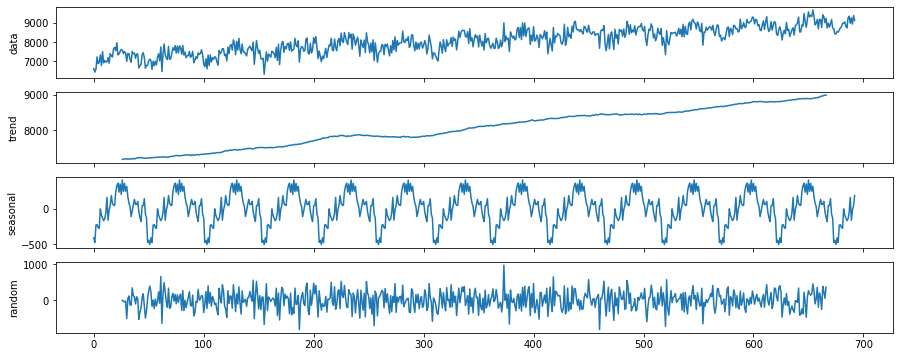

In [13]:
pm.utils.decomposed_plot(
    decomposed_tuple=pm.decompose(train, 'additive', m=52),
    figure_kwargs={'figsize': (15, 6)}
)

In [14]:
max(pm.arima.ndiffs(train, alpha=0.05, test='kpss'),
    pm.arima.ndiffs(train, alpha=0.05, test='adf'),
    pm.arima.ndiffs(train, alpha=0.05, test='pp'))

1

In [15]:
max(pm.arima.nsdiffs(train, m=52, test='ocsb'),
    pm.arima.nsdiffs(train, m=52, test='ch'))

0

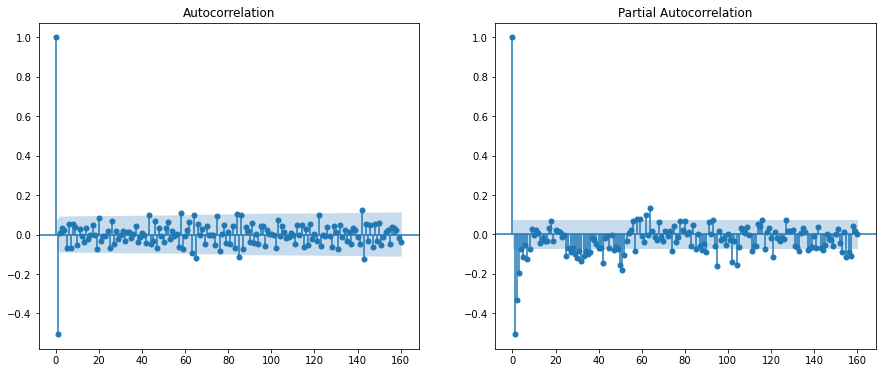

In [16]:
%%capture --no-display
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
pm.plot_acf(train.diff(1).dropna(), alpha=0.05, ax=ax1, show=False, lags=160)
pm.plot_pacf(train.diff(1).dropna(), alpha=0.05, ax=ax2, show=False, lags=160)
plt.show()

In [17]:
pipeline = Pipeline([
    ('model', pm.AutoARIMA(d=1, D=0,
                           start_p=0, start_q=1,
                           start_P=2, start_Q=0,
                           m=52,
                           information_criterion='aicc',
                           method='nm',
                           suppress_warnings=True, 
                           error_action='ignore', 
                           trace=True,
                           with_intercept=False))
#     ('model', pm.ARIMA(order=(0, 1, 1),
#                        seasonal_order=(2, 0, 0, 52),
#                        suppress_warnings=True,
#                        with_intercept=False))
])

In [26]:
%%time

# from pmdarima.arima import StepwiseContext

# with StepwiseContext(max_dur=15):
cv_scores = cross_val_score(
    estimator=pipeline, 
    y=train, 
    scoring='smape', 
    cv=RollingForecastCV(h=52, step=52),
    verbose=2
)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
CPU times: user 13min 47s, sys: 11min 56s, total: 25min 44s
Wall time: 6min 30s


In [27]:
cv_scores.mean(), cv_scores.std()

(3.1607796266409416, 0.6371537661353179)

In [ ]:
# with_intercept=True
(3.562823680238643, 0.9000357623785048)

# with_intercept=False
(3.1607796266409416, 0.6371537661353179)

In [ ]:
pipeline.fit(train)

Performing stepwise search to minimize aicc
 ARIMA(0,1,1)(2,0,0)[52]             : AICC=9906.107, Time=92.84 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AICC=10268.886, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[52]             : AICC=10060.508, Time=9.37 sec
 ARIMA(0,1,1)(0,0,1)[52]             : AICC=9925.209, Time=31.83 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AICC=9917.233, Time=12.09 sec
 ARIMA(0,1,1)(2,0,1)[52]             : AICC=9923.834, Time=143.44 sec
 ARIMA(0,1,1)(1,0,1)[52]             : AICC=9920.146, Time=22.16 sec
 ARIMA(0,1,0)(2,0,0)[52]             : AICC=10270.021, Time=108.87 sec


In [1]:
pipeline.summary()

NameError: name 'pipeline' is not defined

In [84]:
forecast, conf_int = pipeline.predict(n_periods=35, return_conf_int=True)

In [85]:
smape(test, forecast)

13.30952022426241

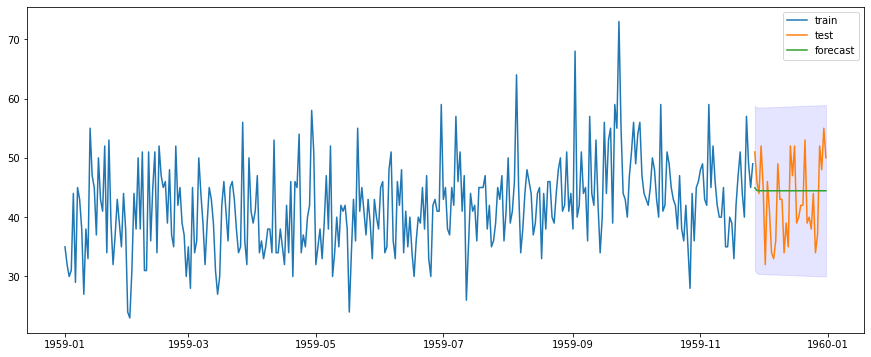

In [86]:
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(test.index, forecast, label='forecast')
plt.fill_between(x=test.index, 
                 y1=conf_int[:, 0], 
                 y2=conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()